In [3]:
library(reshape2)
library(dplyr)
library(igraph)

## Plotting
library(pROC)
library(ggplot2)
theme_set(theme_gray())
library(cowplot)
library(rgl)
library(RColorBrewer)
library(pheatmap)
library(UpSetR)
library(VennDiagram)
library(xtable)
library(Rtsne)
# library(dendextend)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

## Custom
source("../functions.R")

In [8]:
# FUNCTIONS ---------------------------------------------------------------
#' Sorts sample IDs so that they are paired
sort_sid <- function(x) {
  pid <- sapply(x, substring, 1, 4)
  time <- sapply(x, substring, 6, 7)
  time_pid <- mapply(paste0, time, pid)
  return(x[order(time_pid)])
}

#' Boolean function checking that dataframe provided has matching pair names
#' @param X dataframe with paired samples
#' @return logical indicating if it is paired or not
is_paired <- function(X) {
  n <- ncol(X)
  sid_substr <- substring(colnames(X), 1, 4)
  all(sid_substr[1:(n / 2)] == sid_substr[(n / 2 + 1):n])
}

plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# Selecting drug responsive genes between D0 and D8
# using paired t-test and logfc
selectFeatures <- function(df1, metadata_df,
                           alpha = 0.05, logfc_threshold = 1) {
  # Subset df according to D0 and D8
  class_info <- metadata_df[colnames(df1), "class_info"]
  df_d0 <- df1[,class_info == "D0"]
  df_d8 <- df1[,class_info == "D8"]
  print(head(colnames(df_d0)))
  print(head(colnames(df_d8)))
  stopifnot(ncol(df_d0) == ncol(df_d8))
  
  # Identify drug responsive probesets
  ttest_pvalue <- calc_ttest(cbind(df_d0, df_d8), ncol(df_d0), is_paired = T)
  log_fc <- rowMeans(df_d8) - rowMeans(df_d0)
  ttest_probesets <- names(ttest_pvalue)[ttest_pvalue <= alpha]
  fc_probesets <- names(log_fc)[log_fc > logfc_threshold]
  intersect_probesets <- intersect(ttest_probesets, fc_probesets)
  print(paste("T-test:", length(ttest_probesets)))
  print(paste("Log fold change:", length(fc_probesets)))
  print(paste("Intersection:", length(intersect_probesets)))
  return(intersect_probesets)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

plotJitterYeoh <- function(X, metadata_df, n_pc = 10) {
  pca_obj <- prcomp(t(X))
  X_pca <- data.frame(pca_obj$x)
  batch <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class <- as.factor(metadata_df[rownames(X_pca),"class_info"])
  X_meta <- cbind(batch, class, X_pca[,1:n_pc])
  X_long <- melt(X_meta, id = c("batch", "class"), variable.name="PC")
  
  ax_batch <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=batch), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=batch), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  ax_class <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=class), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=class), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  fig <- plot_grid(ax_batch, ax_class, nrow = 2)
  return(fig)  
}

plotFeatures <- function(results, metadata_df) {
  y <- as.factor(metadata_df[rownames(results),"label"])
  subset_features1 <- c("erm1", "angle_d0d8_normal", "l2norm_d0_d8",
                        "l2norm_d0_normal", "l2norm_d8_normal", "l2norm_diff",
                        "erm1_ratio1", "erm1_ratio2", "erm1_ratio3",
                        "l2norm_ratio1", "l2norm_ratio2", "l2norm_diff_ratio")
  
  features1 <- results[, subset_features1, drop=F]
  features1_y <- data.frame(features1, label = y)
  long_features1_y <- melt(features1_y, id="label", variable.name = "feature")
  
  # PLOT: FEATURES
  jitter_features1 <- ggplot(long_features1_y) +
    geom_point(aes(feature, value, colour = label),
               position = position_jitterdodge(), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 2, ncol = 6,  scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
  
  return(jitter_features1)
}

# Factor to split data
splitSubtype <- function(X, metadata_df) {
  if (!is(X, "data.frame"))
    X <- data.frame(X)
  
  subtype_factor <- as.factor(metadata_df[colnames(X), "subtype"])
  split.default(X, subtype_factor, drop = F) # Split by subtype
}

## Import data

In [9]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [10]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

pid_remission <- rownames(Y)[Y$label == 0]

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

In [11]:
## Define train/test split
sid_train1 <- rownames(Y)[
  Y$batch_info %in% 1:5 & Y$class_info != "N" &
  Y$subtype != "Hypodiploid"
]
sid_test1 <- rownames(Y)[
  Y$batch_info %in% 6:10 & Y$class_info != "N" &
  Y$subtype != "Hypodiploid"
]

sid_train2 <- rownames(Y)[
  Y$batch_info %in% 1:5 & Y$class_info != "N" &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others"))
]
sid_test2 <- rownames(Y)[
  Y$batch_info %in% 6:10 & Y$class_info != "N" &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others"))
]

mll_patient <- c("P160_D0", "P160_D8")
sid_train1a <- sort_sid(union(sid_train1, mll_patient))
sid_test1a <- setdiff(sid_test1, mll_patient)

sid_train2a <- sort_sid(union(sid_train2, mll_patient))
sid_test2a <- setdiff(sid_test2, mll_patient)

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [12]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

#### Plot: UpSet

In [ ]:
# list_batch_genes <- list(anova = batch_genes, welch = welch_genes,
#                          kruskal = kruskal_genes)

# upset(fromList(list_batch_genes),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-batch_genes.pdf",
#          width = 8, height = 8)

### Drug genes

Constant: Subtype, remission

In [13]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, pid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  pid_idx <- intersect(pid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[,pid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission)/2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  
  # Median paired log-FC
  paired_logfc <- X_subtype_remission[,-(1:n_pairs)] -
    X_subtype_remission[,1:n_pairs] # D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(X_subtype_remission[,1:n_pairs])
  d8_mu <- rowMeans(X_subtype_remission[,-(1:n_pairs)])
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  feat <- intersect(feat_p, feat_log2fc)
  return(feat)
}

In [14]:
#' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
calcERM <- function(response_df, normal_df) {
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n,]
  d8_df <- response_df[-(1:n),]
  stopifnot(substring(rownames(d8_df),1,4) == substring(rownames(d0_df),1,4))
  
  # Calculate centroids
  leuk_centroid <- apply(d0_df, 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)
}

Setting levels: control = Good, case = Poor
Setting levels: control = Good, case = Poor


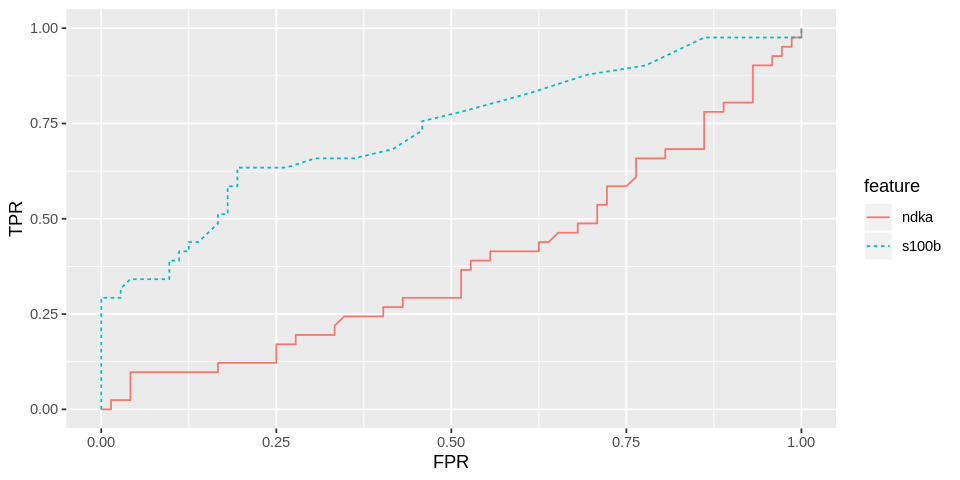

In [26]:
#' @param y vector of labels
#' @param list_x list of vectors containing prediction scores
#' @param bigger.positive logical vector indicating if bigger
#' values have positive labels (e.g. relapse)
plot_proc <- function(y, list_x, x_names, bigger.positive) {
  n <- length(list_x)
  colours <- ggplot_palette(n)
  names(colours) <- x_names
  directions <- ifelse(bigger.positive, "<", ">") # TRUE: controls "<" cases
  
  roc_obj <- roc(y, list_x[[1]],
                 direction = directions[1],
                 ret = "coords")
  roc_df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  
  nrow1 <- nrow(roc_df)
  roc_ord <- roc_df[nrow1:1,] # reverse order of df
  
  gen_addon <- function(i) {
    roc_obj <- roc(y, list_x[[i]], 
                   direction = directions[i],
                   ret = "coords")
    roc_df <- data.frame(
      FPR = 1 - roc_obj$specificities,
      TPR = roc_obj$sensitivities
    )
    
    return(roc_df[nrow(roc_df):1,])
  }
  
  roc_dfs <- lapply(seq(2, n), gen_addon)
  nrows <- sapply(roc_dfs, nrow)
  all_df <- rbind(roc_ord, do.call(rbind, roc_dfs))
  nrows_all <- c(nrow1, nrows)
  feature <- rep(x_names, nrows_all)
  plot_df <- cbind(feature, all_df)
  
  ax_roc <- ggplot(plot_df,
                   aes(FPR, TPR, col = feature, lty = feature),
                   lwd = 3) +
    geom_line()

  return(ax_roc)
}

x_names <- c("s100b", "ndka")
ax_roc <- plot_proc(aSAH$outcome, aSAH[,x_names], x_names, c(T,F))
ax_roc

In [15]:
#' @param Y metadata_df that has rownames corresponding to the
#' @param mrd_global vector of m MRD values where m is the
#' total number of patients being evaluated. For train/test split,
#' please supply mrd of samples that are both remission and in
#' the train set
plotPrediction <- function(results, metadata_df, yeoh_label,
                           mrd_global, idx1_train = NULL, idx1_test = NULL) {
  # Feature selection and rank
  y <- as.factor(metadata_df[rownames(results), "label"])
  features1 <- results[, c("erm1_ratio2", "l2norm_ratio2"), drop = F] # relapse: smaller
  features2 <- results[, "angle_d0d8_normal", drop = F] # relapse: bigger
  
  # MRD
  mrd <- yeoh_label[rownames(results), "d33_mrd"]
  names(mrd) <- rownames(results)
  
  #' NB: Changed from previous calculation! Previous calculations used
  #' pct of samples strictly below value. Calculated  pct locally
  #' Calculates risk of relapse using pct of samples via ranks
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param mrd vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_pct_samples <- function(X1 = NULL, X2 = NULL, mrd) {
    # TODO: Global  will be better!
    # Calculating pct samples for mrd
    n_le_mrd <- rank(mrd, na.last = T, ties.method = "max")
    pct_le_mrd <- n_le_mrd / sum(!is.na(mrd))
    pct_le_mrd[is.na(mrd)] <- NA # NAs are given ranks as well
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      pct_all <- cbind(pct_le, mrd = pct_le_mrd)
    } else if (is.null(X2)) {
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, mrd = pct_le_mrd)
    } else {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, pct_le, mrd = pct_le_mrd)
    }
    
    p <- rowMeans(pct_all, na.rm = T) # final p: average all pct
    
    # Combine with idx,  and label
    pct_samples <- cbind(
      pid = rownames(pct_all),
      label = as.factor(metadata_df[rownames(pct_all), "label"]),
      p,
      pct_all
    )
    
    return(pct_samples)
  }
  
  #' Calculate risk of relapse as percentage of relapse cases with
  #' scores that are better than or equal to the current score
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_p_relapse <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label) {
    #' Pct of relapse cases with worse than or equal to the current score
    #' Bigger values indicate relapse
    #' @param x vector of feature scores from diff samples
    #' @param x_relapse vector of feature scores from relapse samplesor
    calc_pct_relapse_x <- function(x, x_relapse) {
      sapply(x, function(x_i) sum(x_i >= x_relapse)/length(x_relapse))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
    
    # Subset relapse cases
    Y1 <- Y[rownames(X),]
    X_relapse <- X[Y1$label == 1,]

    pct_relapse <- mapply(calc_pct_relapse_x,
                          data.frame(X),
                          data.frame(X_relapse))
    rownames(pct_relapse) <- rownames(X)
    
    # Risk of relapse of is calculated with reference to global set of values
    # Assumption: Y only has rownames that are present in cleaned data
    idx_relapse <- Y$class_info == "D0" & Y$label == 1
    pid_relapse <- substr(rownames(Y)[idx_relapse], 1, 4)
    mrd_relapse <- yeoh_label[pid_relapse, "d33_mrd"]
    global_mrd_relapse <- mrd_relapse[!is.na(mrd_relapse)]
             
    pct_relapse_mrd <- sapply(
      mrd,
      function(x_i) sum(x_i >= global_mrd_relapse) / length(global_mrd_relapse)
    )
    
    pct_relapse_all <- cbind(pct_relapse, pct_relapse_mrd)
    p <- apply(pct_relapse_all, 1, mean, na.rm = T)
    
    p_relapse <- data.frame(
      pid = rownames(pct_relapse_all),
      label = as.factor(metadata_df[rownames(pct_relapse_all), "label"]),
      p,
      pct_relapse_all
    )
    
    return(p_relapse)
  }
             
  #' Calculate probability of remission as percentage of remission cases with
  #' scores that are worse than or equal to the current score
  #' @param X1 df of samples x features where smaller values indicate relapse
  #' @param X2 df of samples x features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return if test.set = F returns df containing pid, label,
  #' risk of relapse, and p of indv features. if test.set = T returns list
  #' of p_remission_train and p_remission_test
  calc_p_remission <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label,
                               mrd_global, idx1_train, idx1_test = NULL) {
    #' Pct of remission cases with worse than or equal to the current score
    #' Bigger values indicate it being worse
    #' @param x vector of feature scores from diff samples
    #' @param x_remission vector of feature scores from relapse samples
    calc_pct_remission_x <- function(x, x_remission) {
      sapply(x, function(x_i) sum(x_i <= x_remission)/length(x_remission))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
    
    idx <- paste0(rownames(X), "_D8") # in order to access metadata
    Y1 <- Y[idx, , drop = F]
    
    if (!is.null(idx1_test)) {
      X_train <- X[idx1_train, , drop = F]
      X_test <- X[idx1_test, , drop = F]
      idx_train <- paste0(rownames(X_train), "_D8") # in order to access metadata
      Y_train <- Y1[idx_train, , drop = F]
      X_train_remission <- X_train[Y_train$label == 0, , drop = F]
      
      print(head(X_train))
      print(head(Y_train))
      
      pct_rem_train <- mapply(calc_pct_remission_x,
                              data.frame(X_train),
                              data.frame(X_train_remission))
      # mapply has >1 return type! Returns a vector in some cases!
      if (!is.matrix(pct_rem_train))
        pct_rem_train <- matrix(pct_rem_train, 1,
                                dimnames =  list(NULL, names(pct_rem_train)))
      
      rownames(pct_rem_train) <- rownames(X_train)
      
      pct_rem_test <- mapply(calc_pct_remission_x,
                             data.frame(X_test),
                             data.frame(X_train_remission))
      # mapply has >1 return type! Returns a vector in some cases!
      if (!is.matrix(pct_rem_test))
        pct_rem_test <- matrix(pct_rem_test, 1,
                                dimnames =  list(NULL, names(pct_rem_test)))
      
      rownames(pct_rem_test) <- rownames(X_test)
      
      ## p(remission|MRD) is calculated with reference to global set of values
      ## Assumption: Y only has rownames that are present in cleaned data
      pct_rem_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= mrd_global) / length(mrd_global)
      ) # pct of remission with a worse score
      
      ## Split MRD into train/test and combine with features
      pct_rem_train_all <- cbind(pct_rem_train,
                                 mrd = pct_rem_mrd[idx1_train])
      pct_rem_test_all <- cbind(pct_rem_test,
                                mrd = pct_rem_mrd[idx1_test])
      
      print(pct_rem_train)
      print(pct_rem_mrd)
      
      p_train <- apply(pct_rem_train_all, 1, mean, na.rm = T)
      p_test <- apply(pct_rem_test_all, 1, mean, na.rm = T)
      
      p_wo_train <- apply(pct_rem_train, 1, mean, na.rm = T)
      p_wo_test <- apply(pct_rem_test, 1, mean, na.rm = T)
      
      idx_train1 <- paste0(rownames(pct_rem_train_all), "_D8")
      idx_test1 <- paste0(rownames(pct_rem_test_all), "_D8")
      
      p_rem_train <- data.frame(
        pid = rownames(pct_rem_train_all),
        label = as.factor(Y[idx_train1, "label"]),
        p = p_train,
        p_wo = p_wo_train, # OPTION: DELETE WHEN PLOTTING
        pct_rem_train_all
      )
      
      p_rem_test <- data.frame(
        pid = rownames(pct_rem_test_all),
        label = as.factor(Y[idx_test1, "label"]),
        p = p_test,
        p_wo = p_wo_test, # OPTION: DELETE WHEN PLOTTING
        pct_rem_test_all
      )
    
      return(list(p_rem_train, p_rem_test))
    } else {
      X_remission <- X[Y1$label == 0,]
      pct_remission <- mapply(calc_pct_remission_x,
                              data.frame(X),
                              data.frame(X_remission))
      rownames(pct_remission) <- rownames(X)

      # Prob of remission is calculated with reference to global set of values
      # Assumption: Y only has rownames that are present in cleaned data
      pct_remission_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= mrd_global) / length(mrd_global)
      ) # pct of remission with a worse score

      pct_remission_all <- cbind(pct_remission, pct_remission_mrd)
      p_wo <- apply(pct_remission, 1, mean, na.rm = T)
      p <- apply(pct_remission_all, 1, mean, na.rm = T)

      p_remission <- data.frame(
        pid = rownames(pct_remission_all),
        label = as.factor(metadata_df[rownames(pct_remission_all), "label"]),
        p = p,
        p_wo = p_wo, # OPTION: DELETE WHEN PLOTTING
        pct_remission_all
      )

      return(p_remission)
    }
  }
  
  pct_samples <- calc_pct_samples(features1, features2, mrd)
  pct_relapse <- calc_p_relapse(features1, features2, mrd,
                                Y = metadata_df, yeoh_label)
  p_remission <- calc_p_remission(
    features1, features2, mrd,
    metadata_df, yeoh_label,
    mrd_global, idx1_train, idx1_test
  )         

  # OPTION: Which method of calculating risk of relapse?
  pred <- p_remission[[1]]
  print(pred)
  # Return final predictions
  p <- pred[, c("p", "p_wo"), drop = F]
  return(p)
  
  # Plot: Jitter - Features and risk_relapse
  X_y <- cbind(
    features1[rownames(pred), , drop = F],
    features2[rownames(pred), , drop = F],
    p = pred$p,
    label = pred$label
  )
             
  print(X_y)
             
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
             
  ax_jitter <- ggplot(long_X_y,
                      aes(feature, value, colour = label)) +
    geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 1, scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
             
  # Plot: Parallel coordinates - Pct
  long_pred <- melt(pred, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_pred,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: CDF
  emp_cdf <- ggplot(pred,
                    aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- pred[order(pred$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
                                
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
                                
  # Plot: ROC
  erm1 <- results[rownames(pred), "erm1"] # depends on p_relapse
  mrd1 <- mrd[rownames(pred)]
  pred_x <- cbind(pred, erm = erm1, mrd = mrd1) # subset mrd
  pred_x_sub <- pred_x[!is.na(pred_x$mrd), , drop = F]
  
  x_names <- c("erm", "mrd", "p")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (length(table(pred_x_sub$label)) > 1) {
    ax_roc <- plot_proc(pred_x_sub$label, pred_x_sub[,x_names],
                        x_names, bigger.positive)
    
    ## T-test
    # Both group sizes must be > 1
    if (min(table(pred$label)) > 1) {
      list_rr <- split(pred$p, pred$label)
      ttest <- t.test(list_rr[[1]], list_rr[[2]])
      p_title <- sprintf("p-value = %.5f", ttest$p.value)      
    } else {
      p_title <- ""
    }
    
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                 ncol = 2, rel_widths = c(1.8, 1))
  } else{
    p_title <- "" # unable to perform t-test
    ax2 <- ax_parallel # unable to plot ROC
  }
                                
  # Plot: T-test           
  ax_ttest <- ggplot(pred,
                     aes(label, p, color = label)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 0.5))
                                
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(pred_x_sub,
                  aes(p, log10(mrd), colour = label)) +
    geom_point(cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))

#   ax1 <- plot_grid(ax_jitter, emp_cdf, ax_rr_or,
#                    ncol = 3, rel_widths = c(2.5, 1.2, 1.3))
#   ax2 <- plot_grid(ax_parallel, mrd_p,
#                    ncol = 2, rel_widths = c(2.5, 1))
  
  # p-value as title
  ax_jitter <- ax_jitter +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 1.0))  
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)

#   return(risk_relapse)
  return(fig)
}

In [710]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_relapse <- function(pid, X, pid_remission, metadata_df,
                            batch_genes = NULL, class_genes = NULL, wpath = NULL) {
  # Check that pid provided is paired
  n <- length(pid)
  pid_substr <- substring(pid, 1, 4)
  if (!all(pid_substr[1:(n/2)] == pid_substr[((n/2)+1):n]))
    stop("Patient IDs are not paired..")
  
  X_subtype <- X[, pid]
  
  # Get subset of genes
  if (is.null(class_genes)) {
    class_genes <- getLocalGenes(X_subtype, pid_remission)
  }
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  pid_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(pid, pid_norm)]
  
  idx <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx,]
  normal <- t(X_fltr_subtype_norm)[-idx,]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
#   print("Results!")
#   print(head(results))
  
#   label <- as.factor(metadata_df[rownames(results), "label"])

#   ax_prediction <- plotPrediction(results, metadata_df, yeoh_label)
  
#   # Plot: Angle v.s. l2norm
#   scatter_plot <- ggplot(results) +
#     geom_point(aes(x = l2norm_d0_d8, y = angle_nl_nd8, col = label),
#                show.legend = F) +
#     scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
#   if (!is.null(wpath))
#     ggsave(wpath, ax_prediction, width = 7, height = 7)
  
  return(results)
}

### Yeoh (2018): Global ERM
- Feature selection: Top 500 down-regulated probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)

In [48]:
### Yeoh (2018): Prediction

## Feature selection
D0 <- data[, 1:201]
D8 <- data[, 202:402]

if (!all(substr(colnames(D0), 1, 4) == substr(colnames(D8), 1, 4)))
  stop("pids do not match!")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

In [49]:
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(data[ps_wilcox, 1:402])
normal <- t(data[ps_wilcox, 403:405])
results <- calcERM(response, normal)
erm <- results[,"erm1", drop = F]

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

In [22]:
subtypes <- setdiff(levels(Y$subtype),
                    c("Hypodiploid", "Normal", "Others"))
subtypes1 <- subtypes
print(subtypes)

[1] "BCR-ABL"      "E2A-PBX1"     "Hyperdiploid" "MLL"          "T-ALL"       
[6] "TEL-AML1"    


In [16]:
# ## Identify all samples under evaluation
# idx_all <- Y$subtype %in% subtypes1

# ## Define train/test split
# idx_global_train <- rownames(Y)[idx_all & Y$label == 0] 
# idx_global_test <- rownames(Y)[idx_all & Y$label == 1]

# ## Global MRD: Remission
# idx_all_rem <- rownames(Y)[idx_all & Y$label == 0]
# idx1_all_rem <- substring(idx_all_rem, 1, 4)
# mrd_rem <- yeoh_label[idx1_all_rem, "d33_mrd"]
# names(mrd_rem) <- idx1_all_rem
# idx1_global_train <- substring(idx_global_train, 1, 4)
# mrd_rem_train <- mrd_rem[idx1_global_train]
# mrd_rem_train1 <- mrd_rem_train[!is.na(mrd_rem_train)]

## TODO: Identify batch effect genes

#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
# Non-locals: pid_remission, Y, X
predict_train_test <- function(subtype,
                               X, Y,
                               pid_remission,
                               mrd_global,
                               idx_global_train,
                               idx_global_test,
                               batch_genes) {
  idx <- rownames(Y)[Y$subtype == subtype]
  n <- length(idx)
  idx1 <- substring(idx, 1, 4)
  
  # Check that pid provided is paired
  if (!all(idx1[1:(n/2)] == idx1[(n/2 + 1):n]))
    stop("Patient IDs are not paired..")
  
  idx_train <- intersect(idx, idx_global_train)
  idx_test <- intersect(idx, idx_global_test)
  ## NOTE: idx1 (pid) is HALF the length of idx (id)!
  idx1_train <- unique(substring(idx_train, 1, 4))
  idx1_test <- unique(substring(idx_test, 1, 4))
  X_train <- X[, idx_train]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(X_train, pid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  idx_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(idx, idx_norm)]
  
  idx_d0d8 <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx_d0d8, ]
  normal <- t(X_fltr_subtype_norm)[-idx_d0d8, ]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
  label <- as.factor(metadata_df[rownames(results), "label"])  
  
  Y <- plotPrediction(results, metadata_df, yeoh_label,
                      mrd_global, idx1_train, idx1_test)
  
  return(results)
}

In [18]:
subtypes1 <- setdiff(subtypes, c("Hyperdiploid", "Others"))

In [26]:
idx_all <- Y$subtype %in% subtypes1
## Define train/test split
idx_global_train <- rownames(Y)[idx_all & Y$label == 0] 
idx_global_test <- rownames(Y)[idx_all & Y$label == 1]
## Collate final prediction from each subtype
list_all <- lapply(subtypes1, predict_train_test,
                   data, Y, pid_remission, NULL,
                   idx_global_train, idx_global_test,
                   batch_genes)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of class genes = " "21"                   
[1] "No. of selected genes = " "14"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of class genes = " "239"                  
[1] "No. of selected genes = " "164"                     
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-f

In [27]:
list_all[[1]][, c("erm1_ratio2", "l2norm_ratio2")]

,erm1_ratio2,l2norm_ratio2
,<dbl>,<dbl>
P053,3.00859111,1.8549851
P054,18.49034613,3.9177600
P055,1.91561680,1.0268466
P056,1.71220343,1.6113608
P057,0.38235771,0.7681211
P134,0.08538801,0.5721590
P152,1.57693518,1.4937770
P170,27.07502471,2.5505411
P175,1.97974800,1.0690815


In [146]:
train_p <- do.call(rbind, list_all)
train_p_ord <- train_p[order(rownames(train_p)), , drop = F] # sort rows
all_y <- yeoh_label[rownames(train_p_ord), c("d33_mrd", "label")]
erm_sub <- erm[rownames(train_p_ord), , drop = F]

print(tail(rownames(train_p_ord))) # check that all rows are ordered the same!!!
print(tail(rownames(erm_sub)))
print(tail(rownames(all_y)))

train_p_y <- cbind(erm_sub,
             train_p_ord,
             all_y)
train_p_y_sub <- train_p_y[!is.na(train_p_y$d33_mrd),]
print(train_p_y_sub)

[1] "P190" "P195" "P196" "P207" "P208" "P211"
[1] "P190" "P195" "P196" "P207" "P208" "P211"
[1] "P190" "P195" "P196" "P207" "P208" "P211"
            erm1         p       p_wo d33_mrd label
P001  72.4693088 0.5690236 0.69696970   5e-04     0
P004  26.0110292 0.5743547 0.75757576   8e-02     0
P005  56.1740685 0.8347363 0.78787879   1e-04     0
P008  80.4078328 0.9483726 0.93939394   1e-04     0
P010   5.3284511 0.4938272 0.33333333   1e-04     0
P012  15.2062574 0.3872054 0.45454545   5e-04     0
P013  70.3467926 0.6301908 0.51515152   1e-04     0
P014  40.6700798 0.5771605 0.44444444   1e-04     0
P015  30.2995227 0.2233446 0.25252525   7e-04     0
P016  23.7576810 0.3574635 0.15151515   1e-04     0
P017  62.0457473 0.7968575 0.73737374   1e-04     0
P018   8.0174993 0.2968575 0.07070707   1e-04     0
P022  21.7618791 0.3726150 0.17171717   1e-04     0
P023 -49.0432400 0.1346801 0.08080808   2e-04     0
P024  54.0243328 0.5317059 0.38383838   1e-04     0
P025  60.1526724 0.6074635 0.4

In [132]:
test_p <- do.call(rbind, list_all)
test_p_ord <- test_p[order(rownames(test_p)), , drop = F] # sort rows
all_y <- yeoh_label[rownames(test_p_ord), c("d33_mrd", "label")]
erm_sub <- erm[rownames(test_p_ord), , drop = F]

print(tail(rownames(test_p_ord))) # check that all rows are ordered the same!!!
print(tail(rownames(erm_sub)))
print(tail(rownames(all_y)))

test_p_y <- cbind(erm_sub,
             test_p_ord,
             all_y)
test_p_y_sub <- p_y[!is.na(p_y$d33_mrd),]

[1] "P151" "P152" "P164" "P167" "P184" "P189"
[1] "P151" "P152" "P164" "P167" "P184" "P189"
[1] "P151" "P152" "P164" "P167" "P184" "P189"


In [158]:
all_p_y <- rbind(train_p_y_sub, test_p_y_sub)
all_p_y$d33_mrd <- -log10(all_p_y$d33_mrd) 
long_all_p_y <- melt(all_p_y, id.vars = "label", variable.name = "feature")
print(head(long_all_p_y))

ax_jitter <- ggplot(long_all_p_y, aes(x = feature, y = value, col = as.factor(label))) +
  geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
  scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
  facet_wrap(~feature, nrow = 1, scales = "free")

ggsave("~/Dropbox/temp/jitter-trainrem_testrel.pdf",
       ax_jitter, width = 12, height = 6)

  label feature     value
1     0    erm1 72.469309
2     0    erm1 26.011029
3     0    erm1 56.174068
4     0    erm1 80.407833
5     0    erm1  5.328451
6     0    erm1 15.206257


In [159]:
print(all_p_y)

            erm1           p       p_wo   d33_mrd label
P001  72.4693088 0.569023569 0.69696970 3.3010300     0
P004  26.0110292 0.574354658 0.75757576 1.0969100     0
P005  56.1740685 0.834736251 0.78787879 4.0000000     0
P008  80.4078328 0.948372615 0.93939394 4.0000000     0
P010   5.3284511 0.493827160 0.33333333 4.0000000     0
P012  15.2062574 0.387205387 0.45454545 3.3010300     0
P013  70.3467926 0.630190797 0.51515152 4.0000000     0
P014  40.6700798 0.577160494 0.44444444 4.0000000     0
P015  30.2995227 0.223344557 0.25252525 3.1549020     0
P016  23.7576810 0.357463524 0.15151515 4.0000000     0
P017  62.0457473 0.796857464 0.73737374 4.0000000     0
P018   8.0174993 0.296857464 0.07070707 4.0000000     0
P022  21.7618791 0.372615039 0.17171717 4.0000000     0
P023 -49.0432400 0.134680135 0.08080808 3.6989700     0
P024  54.0243328 0.531705948 0.38383838 4.0000000     0
P025  60.1526724 0.607463524 0.48484848 4.0000000     0
P026  14.0098476 0.172278339 0.15151515 3.522878

In [ ]:
# ax_roc <- plot_proc(p_y_sub$label, p_y_sub[, 1:4],
#                     c("ERM", "p", "p_wo", "MRD"), c(F, F, F, T))
# ggsave("~/Dropbox/temp/roc-all.pdf", ax_roc,
#        height = 6, width = 6.5)

#### Plot x v.s. TPR

In [ ]:
plot_tpr1 <- function(x, name, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  plot(TPR, sort_x, ylab = name, col = col, type = "l")
}


plot_tpr2 <- function(x, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  lines(TPR, sort_x, col = col, type = "l")
}

cols <- ggplot_palette(4)
features <- c("ERM", "p", "p (w/o MRD)", "-log10(MRD)")

pdf("~/Dropbox/temp/tpr_x.pdf", 6, 6)
plot_tpr1(normaliseMinmax(p_y_sub$erm1), "x", cols[1])
plot_tpr2(p_y_sub$p, cols[2])
plot_tpr2(p_y_sub$p_wo, cols[3])
plot_tpr2(normaliseMinmax(-log10(p_y_sub$d33_mrd)), cols[4])
legend("topleft", legend = features, col = cols, lwd=2)
dev.off()

#### Plotting: Features, ROC, T-test

In [985]:
for (subtype in subtypes1) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  wpath <- sprintf("~/Dropbox/temp/results_test-%s.pdf", subtype)
  p <- predict_relapse(pid_subtype, data, pid_remission, Y,
                       batch_genes = batch_genes)
  print(p)
  break
#   ggsave(wpath, ax_roc, width = 12, height = 7)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
        erm1_ratio2 l2norm_ratio2 angle_d0d8_normal
P053_D8   0.6666667     0.6666667         0.6666667
P054_D8   1.0000000     1.0000000         1.0000000
P055_D8   0.3333333     0.3333333         0.3333333
P056_D8   0.0000000     0.3333333         0.0000000
P057_D8   0.0000000     0.0000000         0.0000000
[1] "matrix"


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


$`0`
[1] 0.4644608 0.5000000

$`1`
[1] 0.003676471 0.083333333 0.000000000

                  p
P134_D8 0.003676471
P152_D8 0.083333333
P170_D8 0.464460784
P175_D8 0.500000000
P184_D8 0.000000000


### Breakdown of train and test sets

In [960]:
## Breakdown of train and test sets
idx1 <- Y$batch_info %in% 1:5 & Y$class_info == "D0"
idx2 <- !(Y$batch_info %in% 1:5) & Y$class_info == "D0"
Y_train <- Y[idx1,]
Y_test <- Y[idx2,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(xtable(tab_test))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Thu Nov 12 01:34:19 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   2 &   3 \\ 
  E2A-PBX1 &   2 &   2 \\ 
  Hyperdiploid &  22 &   4 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   5 \\ 
  Normal &   0 &   0 \\ 
  Others &  37 &  16 \\ 
  T-ALL &   2 &   1 \\ 
  TEL-AML1 &  13 &   1 \\ 
   \hline
\end{tabular}
\end{table}


#### Prediction (D-B): All subtypes

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal"   
[19] "l2norm_d8_normal"    "l2norm_ratio1" 

Setting levels: control = 0, case = 1


[1] 2


Setting levels: control = 0, case = 1


[1] 3


Setting levels: control = 0, case = 1
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal"   
[19] "l2norm_d8_normal"    "l2norm_ratio1"       "l2norm_ratio2"      
[22] "l2norm_diff"         "l2norm_d

ERROR: Error in roc.default(x, predictor, plot = TRUE, ...): 'response' must have two levels


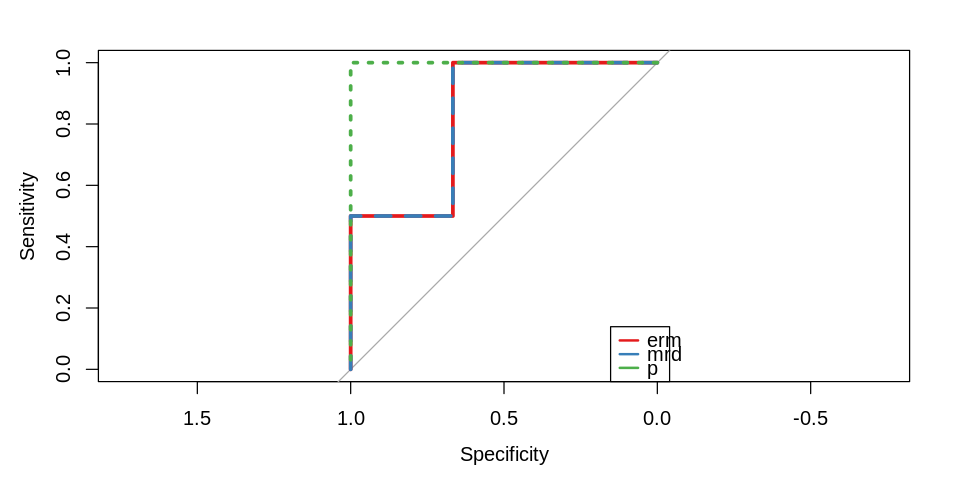

In [736]:
for (subtype in subtypes) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  wpath <- sprintf("~/Dropbox/temp/risk_relapse_long-%s.pdf", subtype)
  predict_relapse(pid_subtype, data, pid_remission, Y,
                  batch_genes = batch_genes, wpath = wpath)
}

#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


## Subnetworks

In [8]:
# 1. Removes affymetrix ambiguous and control probesets
# 2. Map probesets to IDs
# Removes one-to-many probesets and probesets with no ID
# Selects maximum if two probesets match to same gene
# CHECK: What microarray platform is the data from?
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_data <- affy2id(data, ENTREZ_GPL570)

## SYMBOL_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
## symbol_yeoh <- affy2id(data_yeoh, SYMBOL_GPL570)

No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [572]:
# Calculate individual D0-N magnitude (normal centroid)
normal <- entrez_data[, startsWith(colnames(entrez_data), "N")]
D0 <- entrez_data[, endsWith(colnames(entrez_data), "D0")]
D8 <- entrez_data[, endsWith(colnames(entrez_data), "D8")]

#### Unfiltered data

In [573]:
raw_data <- log2_transform(selected_yeoh)
araw <- affy2id(raw_data, ENTREZ_GPL570)
lidx1 <- sapply(subnetwork_nea,
                function(ids) all(ids %in% rownames(araw)))
subnetwork2 <- subnetwork_nea[lidx1]
print(length(subnetwork2))
                
# Calculate individual D0-N magnitude (normal centroid)
normal_raw <- araw[, startsWith(colnames(araw), "N")]
D0_raw <- araw[, endsWith(colnames(araw), "D0")]
D8_raw <- araw[, endsWith(colnames(araw), "D8")]

No. of probesets mapping to multiple IDs removed: 412
No. of probesets with no ID removed: 1010
Total no. of probesets removed (incl. probesets mapping to same gene): 4185
[1] 4715


#### Import subnetworks

In [ ]:
## Import NEA subnetworks
NEA_RPATH <- paste0("../diff_expr/data/subnetwork/nea-hsa/",
                    "ovarian_cancer/geneset-nea_kegg_ovarian.tsv")
nea_df <- read.table(NEA_RPATH, sep = "\t", header = T, stringsAsFactors = F)
subnetwork_nea <- split(as.character(nea_df$gene_id), nea_df$subnetwork_id)

In [570]:
# Filter out subnetworks with genes that are missing in the data
lidx <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(entrez_data)))
nea_fltr <- subnetwork_nea[lidx]
               
lidx1 <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(araw)))
nea_unfltr <- subnetwork_nea[lidx1]

In [728]:
print(length(subnetwork_nea))
print(length(nea_unfltr))

[1] 4715
[1] 4715


#### Only half of the KEGG ids are represented in the data

In [539]:
## Import KEGG pathways
KEGG_RPATH <- "../info/KEGG/kegg-human_allpathway_genes.tsv"
kegg_df <- read.table(KEGG_RPATH, sep = "\t", header = T, stringsAsFactors = F)
kegg_df$Pathway <- substring(kegg_df$Pathway, 6)
list_kegg <- split(kegg_df$Entrez.Gene.ID, kegg_df$Pathway)

In [549]:
sum(unique(unlist(list_kegg)) %in% rownames(araw))

[1] 3839

In [551]:
# kegg_size <- sapply(subnetwork_pwapi, length)
# kegg_hit <- sapply(subnetwork_pwapi,
#                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data
incomplete_kegg <- lapply(list_kegg,
                          function(ids) ids[ids %in% rownames(araw)])
kegg_size <- sapply(incomplete_kegg, length)
SIZE <- 5
incomplete_kegg_sub <- incomplete_kegg[kegg_size > SIZE]
kegg_size1 <- sapply(incomplete_kegg_sub, length)

In [417]:
## Import pathwayAPI
PWAPI_RPATH <- "../info/pathwayAPI/pwapi_id_human-filtered_entrez.tsv"
pwapi_df <- read.table(PWAPI_RPATH, sep = "\t", header = T, stringsAsFactors = F)
list_pwapi <- split(pwapi_df[,2:3], pwapi_df$pathway_id)
subnetwork_pwapi <- lapply(list_pwapi,
                           function(X) unique(as.numeric(data.matrix(X))))

In [466]:
pwapi_size <- sapply(subnetwork_pwapi, length)
pwapi_hit <- sapply(subnetwork_pwapi,
                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data in pathwayAPI
subnetwork_pwapi_sub <- lapply(subnetwork_pwapi,
                                function(ids) ids[ids %in% rownames(araw)])
pwapi_size1 <- sapply(subnetwork_pwapi_sub, length)
SIZE <- 5
subnetwork_pwapi_sub1 <- subnetwork_pwapi_sub[pwapi_size1 > SIZE]
pwapi_size2 <- sapply(subnetwork_pwapi_sub1, length)
print(cbind(pwapi_hit[pwapi_size1 > SIZE], pwapi_size2))

             pwapi_size2
pwapi002  10          10
pwapi003 144         144
pwapi004  36          36
pwapi005  67          67
pwapi006  39          39
pwapi007  43          43
pwapi008  14          14
pwapi012   6           6
pwapi016  11          11
pwapi017  28          28
pwapi018  24          24
pwapi019  23          23
pwapi020  29          29
pwapi021  44          44
pwapi022  55          55
pwapi023   8           8
pwapi024 116         116
pwapi025  30          30
pwapi026  17          17
pwapi029  75          75
pwapi030 139         139
pwapi031  27          27
pwapi032  27          27
pwapi033  27          27
pwapi034  28          28
pwapi036  13          13
pwapi037  22          22
pwapi038  12          12
pwapi040  16          16
pwapi041  18          18
pwapi042  10          10
pwapi044  32          32
pwapi045 108         108
pwapi046  54          54
pwapi048  68          68
pwapi049  32          32
pwapi050  11          11
pwapi051  23          23
pwapi052  28          28


#### Subnetwork deltas (D0-N)
- Comparing variance of subnetwork deltas was not conclusive
- Means of the random sample seem to have a larger proportion of higher mean subnetworks

- Sum of deltas (D0-D8) is not a good feature
- Percentage of sum of deltas is not a good feature
    - Does not take into account the sign of the logfc
    - Does not consider individual subnetwork
- Percentage of each subnetwork
    - Filter out subnetwork that has delta_D0N of less than threshold?

In [571]:
#' @param ids vector of gene IDs belonging to a subnetwork
#' @param X dataframe of expr values at D0
#' @param Y vector or dataframe of expr values at specific timepoint
#' @return vector of deltas of patients of a particular subnetwork
calc_subnetwork_delta <- function(ids, X, Y) {
  if(is.numeric(ids)) # how to handle factor?
    ids <- as.character(ids)
  
  if (is.vector(Y)) {
    logfc <- Y[ids] - X[ids,]
  } else {
    stopifnot(substring(colnames(X),1,4) ==
              substring(colnames(Y),1,4))
    logfc <- Y[ids,] - X[ids,]
  }
  return(colMeans(abs(logfc)))
}

In [651]:
# Plots batches in different colours and classes in different symbols
plotPCA2D <- function(df1, metadata_df, pc_labels = NULL) {
  # Obtaining batch and class annotations
  batch_factor <- as.factor(metadata_df[colnames(df1),"label"])
  class_factor <- metadata_df[colnames(df1), "subtype"]
  print(head(batch_factor))
  print(head(class_factor))
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(df1))
    pca_df <- data.frame(pca_obj$x[,1:4])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(df1)
  }
  
  pc1_pc2 <- ggplot(pca_df, aes(x = PC1, y = PC2, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  # theme(plot.title = element_text(hjust = 0.5))

  pc1_pc3 <- ggplot(pca_df, aes(x = PC1, y = PC3, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = F) +
    labs(x = pc_labels[1], y = pc_labels[3]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)

  pca_plot <- plot_grid(pc1_pc2, pc1_pc3)
  
  return(pca_plot)
}

#### Filtered data - NEA

In [574]:
norm_centroid <- rowMeans(normal)

delta_D0N <- data.frame(t(sapply(nea_fltr,
                                 calc_subnetwork_delta,
                                 D0, norm_centroid)))
delta_D0D8 <- data.frame(t(sapply(nea_fltr,
                                  calc_subnetwork_delta,
                                  D0, D8)))

In [658]:
print(length(nea_unfltr))

[1] 4715


[1] "BCR-ABL"
[1] 9


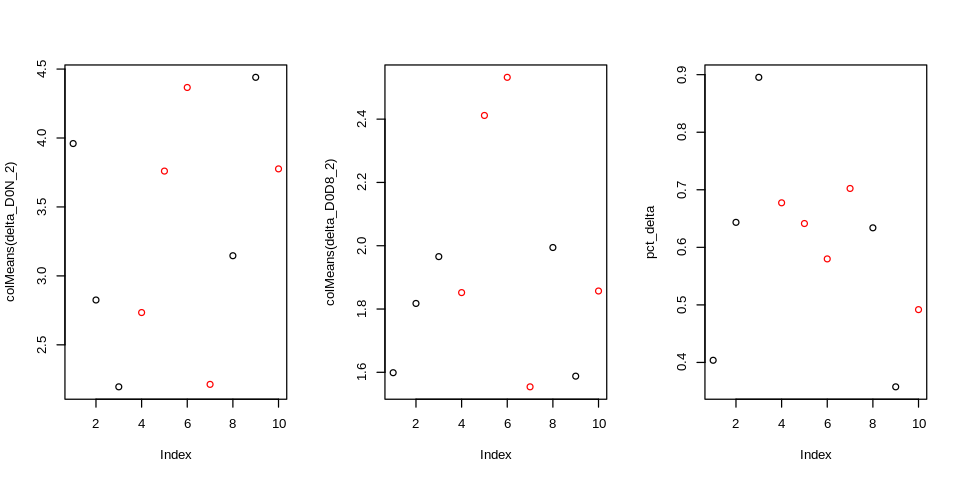

In [669]:
subtype <- subtypes[[1]]
print(subtype)
delta_D0N_1 <- delta_D0N[
  , Y[colnames(delta_D0N), "subtype"] == subtype
]
delta_D0D8_1 <- delta_D0D8[
  , Y[colnames(delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

mu_delta <- apply(delta_D0N_1, 1, mean)
var_delta <- apply(delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)

THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))
delta_D0D8_2 <- delta_D0D8_1[idx_subnetwork, ]
delta_D0N_2 <- delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- colMeans(delta_D0D8_2) / colMeans(delta_D0N_2)

par(mfrow=c(1,3))
plot(colMeans(delta_D0N_2), col = Y[names(pct_delta), "label"] + 1)
plot(colMeans(delta_D0D8_2), col = Y[names(pct_delta), "label"] + 1)
plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

In [662]:
print(colnames(delta_D0D8_1)[Y[colnames(delta_D0D8_1), "label"] == 1])

[1] "P056_D8" "P057_D8" "P134_D8" "P152_D8" "P184_D8"


[1] 0 0 0 0 0 0
Levels: 0 1
[1] TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1
9 Levels: BCR-ABL E2A-PBX1 Hyperdiploid Hypodiploid MLL Normal ... TEL-AML1


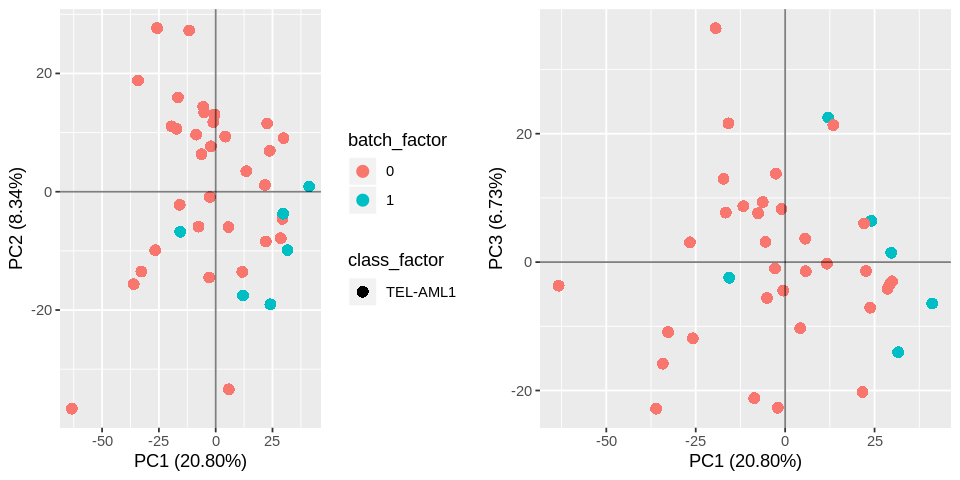

In [653]:
plotPCA2D(raw_delta_D0D8_1, Y)

#### Unfiltered data - NEA

In [641]:
norm_centroid1 <- rowMeans(normal_raw)

raw_delta_D0N <- data.frame(t(sapply(nea_unfltr,
                                 calc_subnetwork_delta,
                                 D0_raw, norm_centroid1)))
raw_delta_D0D8 <- data.frame(t(sapply(nea_unfltr,
                                  calc_subnetwork_delta,
                                  D0_raw, D8_raw)))

In [734]:
for (subtype in subtypes) {
  print(subtype)
  raw_delta_D0N_1 <- raw_delta_D0N[
    , Y[colnames(raw_delta_D0N), "subtype"] == subtype
  ]
  raw_delta_D0D8_1 <- raw_delta_D0D8[
    , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
  ]

  stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
            substring(colnames(raw_delta_D0D8_1),1,4))

  mu_delta <- apply(raw_delta_D0N_1, 1, mean)
  var_delta <- apply(raw_delta_D0N_1, 1, var)
  # plot(mu_delta, var_delta)
  THRESHOLD <- 3
  idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]

  ## Selecting subnetworks with significant dysregulation
  raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
  raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

  # print(colnames(delta_D0D8_1)[
  #   Y[colnames(delta_D0D8_1), "label"] == 1
  # ])

  pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
  
  #   pct_delta_rem <- pct_delta[, Y[colnames(pct_delta), "label"] == 0]
#   mean_pct <- rowMeans(pct_delta_rem)
#   PCT <- 0.7
#   nea_responsive <- names(mean_pct)[mean_pct > PCT]
#   print(length(nea_responsive))
#   pct_delta_responsive <- colMeans(pct_delta[nea_responsive, ])

  fpath <- sprintf("~/Dropbox/temp/delta-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(raw_delta_D0N_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0N)",
       pch = 16, cex = 1.5)
  plot(colMeans(raw_delta_D0D8_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0D8)",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(pct_delta)",
       pch = 16, cex = 1.5)
#   plot(pct_delta_responsive,
#        col = Y[names(pct_delta), "label"] + 1,
#        ylab = "mean_responsive(pct_delta)")
  dev.off()
  
  ## Relapse prediction
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  feat <- predict_relapse(pid_subtype, data, pid_remission, Y,
                          batch_genes = batch_genes)  
  
  fpath <- sprintf("~/Dropbox/temp/delta_corr-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(pct_delta), feat[, "erm1_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "erm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "l2norm_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "l2norm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "angle_d0d8_normal"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "angle_d0d8_normal",
       pch = 16, cex = 1.5)
  dev.off()
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1

In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


#### Unfiltered data - PathwayAPI

In [484]:
norm_centroid1 <- rowMeans(normal_raw)

pwapi_delta_D0N <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
pwapi_delta_D0D8 <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [535]:
subtype <- subtypes[[4]]
print(subtype)
pwapi_delta_D0N_1 <- pwapi_delta_D0N[
  , Y[colnames(pwapi_delta_D0N), "subtype"] == subtype
]
pwapi_delta_D0D8_1 <- pwapi_delta_D0D8[
  , Y[colnames(pwapi_delta_D0D8), "subtype"] == subtype
]

[1] "MLL"


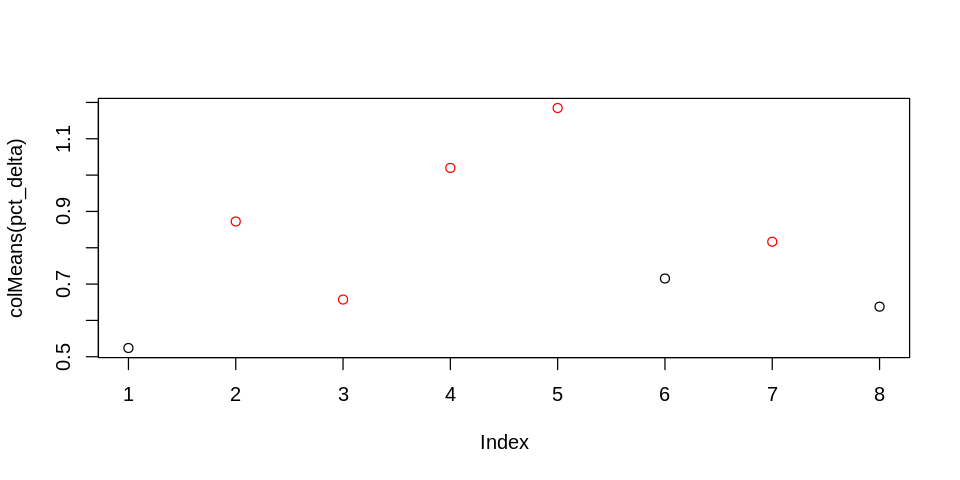

In [536]:
stopifnot(substring(colnames(pwapi_delta_D0N_1),1,4) ==
          substring(colnames(pwapi_delta_D0D8_1),1,4))

pwapi_mu_delta <- apply(pwapi_delta_D0N_1, 1, mean)
pwapi_var_delta <- apply(pwapi_delta_D0N_1, 1, var)
# plot(pwapi_mu_delta, pwapi_var_delta)

THRESHOLD <- 2.5
idx_subnetwork3 <- names(pwapi_mu_delta)[pwapi_mu_delta > THRESHOLD]
pwapi_delta_D0D8_2 <- pwapi_delta_D0D8_1[idx_subnetwork3, ]
pwapi_delta_D0N_2 <- pwapi_delta_D0N_1[idx_subnetwork3, ]

# print(colnames(pwapi_delta_D0D8_1)[
#   Y[colnames(pwapi_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- pwapi_delta_D0D8_2 / pwapi_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Unfiltered data - KEGG

In [552]:
norm_centroid1 <- rowMeans(normal_raw)

kegg_delta_D0N <- data.frame(t(sapply(incomplete_kegg_sub,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
kegg_delta_D0D8 <- data.frame(t(sapply(incomplete_kegg_sub,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [566]:
subtype <- subtypes[[7]]
print(subtype)
kegg_delta_D0N_1 <- kegg_delta_D0N[
  , Y[colnames(kegg_delta_D0N), "subtype"] == subtype
]
kegg_delta_D0D8_1 <- kegg_delta_D0D8[
  , Y[colnames(kegg_delta_D0D8), "subtype"] == subtype
]

[1] "TEL-AML1"


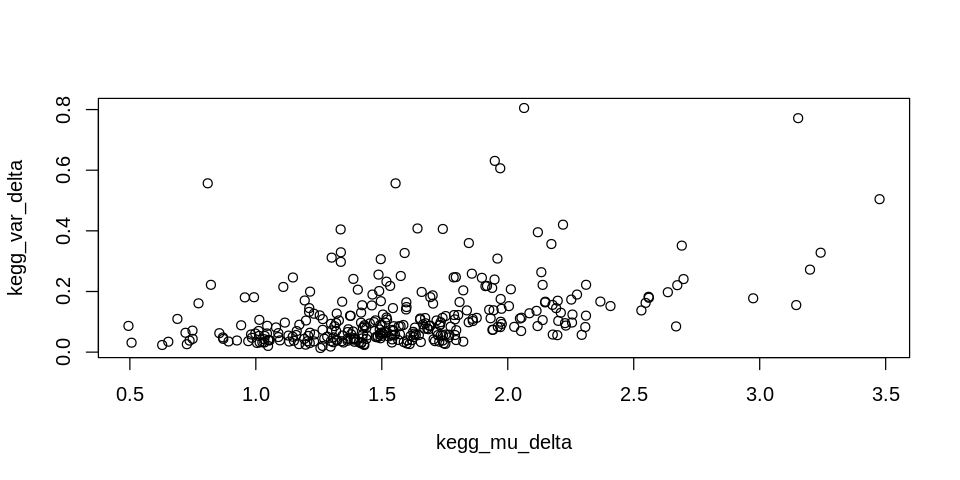

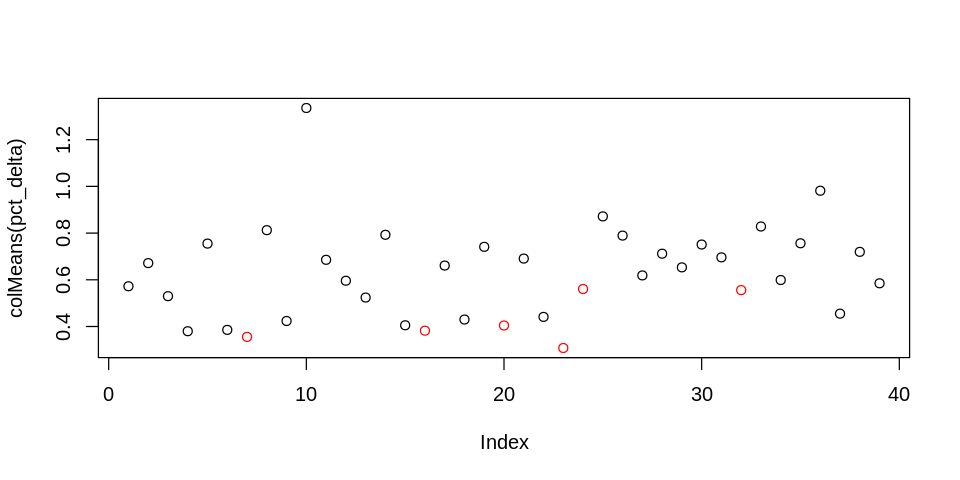

In [567]:
stopifnot(substring(colnames(kegg_delta_D0N_1),1,4) ==
          substring(colnames(kegg_delta_D0D8_1),1,4))

kegg_mu_delta <- apply(kegg_delta_D0N_1, 1, mean)
kegg_var_delta <- apply(kegg_delta_D0N_1, 1, var)
plot(kegg_mu_delta, kegg_var_delta)

THRESHOLD <- 2
idx_subnetwork4 <- names(kegg_mu_delta)[kegg_mu_delta > THRESHOLD]
kegg_delta_D0D8_2 <- kegg_delta_D0D8_1[idx_subnetwork4, ]
kegg_delta_D0N_2 <- kegg_delta_D0N_1[idx_subnetwork4, ]

# print(colnames(kegg_delta_D0D8_1)[
#   Y[colnames(kegg_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- kegg_delta_D0D8_2 / kegg_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Misc

In [49]:
## Distribution of subnetwork sizes
subnetwork_sizes <- sapply(subnetwork_nea, length)
print(table(subnetwork_sizes))

## Representation of gene IDs in data
all_ids <- unlist(subnetwork_nea)
print(head(sort(names(table(all_ids)))))
print(head(sort(rownames(entrez_data))))

[1] "10"        "100"       "10000"     "10010"     "100131827" "10014"    
[1] "100"       "10000"     "10001"     "10005"     "10010"     "100127972"


In [736]:
dim(data)

[1] 5453  405

#### Data
- 405 samples (201 D0, 201 D8,3 N)
- Originally 210 patients
- Removed 2 outliers, 7 different batches

In [747]:
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")

[1] "P001_D0"  "P004_D0"  "P005_D0"  "P007_D0"  "P008_D0"  "P009_D0" 
  [7] "P010_D0"  "P011_D0"  "P012_D0"  "P013_D0"  "P014_D0"  "P015_D0" 
 [13] "P016_D0"  "P017_D0"  "P018_D0"  "P019_D0"  "P020_D0"  "P022_D0" 
 [19] "P023_D0"  "P024_D0"  "P025_D0"  "P026_D0"  "P027_D0"  "P028_D0" 
 [25] "P029_D0"  "P031_D0"  "P032_D0"  "P033_D0"  "P034_D0"  "P035_D0" 
 [31] "P036_D0"  "P037_D0"  "P038_D0"  "P039_D0"  "P040_D0"  "P041_D0" 
 [37] "P042_D0"  "P043_D0"  "P044_D0"  "P046_D0"  "P047_D0"  "P048_D0" 
 [43] "P049_D0"  "P050_D0"  "P051_D0"  "P053_D0"  "P054_D0"  "P055_D0" 
 [49] "P056_D0"  "P057_D0"  "P058_D0"  "P059_D0"  "P060_D0"  "P061_D0" 
 [55] "P062_D0"  "P063_D0"  "P064_D0"  "P065_D0"  "P066_D0"  "P067_D0" 
 [61] "P068_D0"  "P070_D0"  "P071_D0"  "P072_D0"  "P073_D0"  "P075_D0" 
 [67] "P076_D0"  "P077_D0"  "P078_D0"  "P080_D0"  "P081_D0"  "P082_D0" 
 [73] "P083_D0"  "P084_D0"  "P085_D0"  "P086_D0"  "P087_D0"  "P088_D0" 
 [79] "P089_D0"  "P090_D0"  "P091_D0"  "P092_D0"  "P093_D0"  "P094_D0" 
 [85] "P095_D0"  "P096_D0"  "P097_D0"  "P098_D0"  "P099_D0"  "P100_D0" 
 [91] "P101_D0"  "P102_D0"  "P103_D0"  "P104_D0"  "P105_D0"  "P106_D0" 
 [97] "P107_D0"  "P108_D0"  "P109_D0"  "P110_D0"  "P111_D0"  "P112_D0" 
[103] "P113_D0"  "P114_D0"  "P115_D0"  "P116_D0"  "P117_D0"  "P118_D0" 
[109] "P119_D0"  "P120_D0"  "P121_D0"  "P122_D0"  "P123_D0"  "P124_D0" 
[115] "P125_D0"  "P126_D0"  "P127_D0"  "P128_D0"  "P129_D0"  "P130_D0" 
[121] "P131_D0"  "P132_D0"  "P133_D0"  "P134_D0"  "P135_D0"  "P136_D0" 
[127] "P137_D0"  "P138_D0"  "P139_D0"  "P140_D0"  "P141_D0"  "P142_D0" 
[133] "P143_D0"  "P144_D0"  "P145_D0"  "P146_D0"  "P147_D0"  "P148_D0" 
[139] "P149_D0"  "P150_D0"  "P151_D0"  "P152_D0"  "P153_D0"  "P154_D0" 
[145] "P155_D0"  "P156_D0"  "P157_D0"  "P158_D0"  "P159_D0"  "P160_D0" 
[151] "P161_D0"  "P162_D0"  "P163_D0"  "P164_D0"  "P165_D0"  "P166_D0" 
[157] "P167_D0"  "P168_D0"  "P169_D0"  "P170_D0"  "P171_D0"  "P172_D0" 
[163] "P173_D0"  "P174_D0"  "P175_D0"  "P176_D0"  "P177_D0"  "P178_D0" 
[169] "P179_D0"  "P180_D0"  "P181_D0"  "P182_D0"  "P183_D0"  "P184_D0" 
[175] "P185_D0"  "P187_D0"  "P188_D0"  "P189_D0"  "P190_D0"  "P191_D0" 
[181] "P192_D0"  "P193_D0"  "P194_D0"  "P195_D0"  "P196_D0"  "P197_D0" 
[187] "P199_D0"  "P200_D0"  "P201_D0"  "P202_D0"  "P203_D0"  "P204_D0" 
[193] "P205_D0"  "P206_D0"  "P207_D0"  "P208_D0"  "P209_D0"  "P210_D0" 
[199] "P211_D0"  "P212_D0"  "P213_D0"  "P214_D0"  "P215_D0"  "P216_D0" 
[205] "P217_D0"  "P218_D0"  "P219_D0"  "P220_D0"  "P001_D8"  "P004_D8" 
[211] "P005_D8"  "P007_D8"  "P008_D8"  "P009_D8"  "P010_D8"  "P011_D8" 
[217] "P012_D8"  "P013_D8"  "P014_D8"  "P015_D8"  "P016_D8"  "P017_D8" 
[223] "P018_D8"  "P019_D8"  "P020_D8"  "P022_D8"  "P023_D8"  "P024_D8" 
[229] "P025_D8"  "P026_D8"  "P027_D8"  "P028_D8"  "P029_D8"  "P031_D8" 
[235] "P032_D8"  "P033_D8"  "P034_D8"  "P035_D8"  "P036_D8"  "P037_D8" 
[241] "P038_D8"  "P039_D8"  "P040_D8"  "P041_D8"  "P042_D8"  "P043_D8" 
[247] "P044_D8"  "P046_D8"  "P047_D8"  "P048_D8"  "P049_D8"  "P050_D8" 
[253] "P051_D8"  "P053_D8"  "P054_D8"  "P055_D8"  "P056_D8"  "P057_D8" 
[259] "P058_D8"  "P059_D8"  "P060_D8"  "P061_D8"  "P062_D8"  "P063_D8" 
[265] "P064_D8"  "P065_D8"  "P066_D8"  "P067_D8"  "P068_D8"  "P070_D8" 
[271] "P071_D8"  "P072_D8"  "P073_D8"  "P075_D8"  "P076_D8"  "P077_D8" 
[277] "P078_D8"  "P080_D8"  "P081_D8"  "P082_D8"  "P083_D8"  "P084_D8" 
[283] "P085_D8"  "P086_D8"  "P087_D8"  "P088_D8"  "P089_D8"  "P090_D8" 
[289] "P091_D8"  "P092_D8"  "P093_D8"  "P094_D8"  "P095_D8"  "P096_D8" 
[295] "P097_D8"  "P098_D8"  "P099_D8"  "P100_D8"  "P101_D8"  "P102_D8" 
[301] "P103_D8"  "P104_D8"  "P105_D8"  "P106_D8"  "P107_D8"  "P108_D8" 
[307] "P109_D8"  "P110_D8"  "P111_D8"  "P112_D8"  "P113_D8"  "P114_D8" 
[313] "P115_D8"  "P116_D8"  "P117_D8"  "P118_D8"  "P119_D8"  "P120_D8" 
[319] "P121_D8"  "P122_D8"  "P123_D8"  "P124_D8"  "P125_D8"  "P126_D8" 
[325] "P127_D8"  "P128_D8"  "P129_D8"  "P130_D8"  "P131_D8"  "P132_D8" 
[331] "P133_D8"  "P134_D8"  "P135_D8"  "P1